In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import os
from pathlib import Path

In [2]:
PATH_CUR = os.getcwd()
p = Path(PATH_CUR)
p.parents[0]

WindowsPath('D:/github_repos/MLOps')

In [47]:
df = pd.read_parquet(os.path.join(p.parents[0], 'data/green_tripdata_2021-01.parquet'))
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [48]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [48]:
df.iloc[0]['lpep_dropoff_datetime'] - df.iloc[0]['lpep_pickup_datetime']

Timedelta('0 days 00:03:56')

In [49]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df[['duration']]

,duration
0,0 days 00:03:56
1,0 days 00:08:45
2,0 days 00:05:58
3,0 days 00:07:05
4,0 days 00:00:04
...,...
76513,0 days 00:38:00
76514,0 days 00:38:00
76515,0 days 00:11:00
76516,0 days 00:27:00


In [50]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df[['duration']]

,duration
0,3.933333
1,8.750000
2,5.966667
3,7.083333
4,0.066667
...,...
76513,38.000000
76514,38.000000
76515,11.000000
76516,27.000000


In [12]:
df_type2 = df[df.trip_type == 2.0]
df_type2.duration.describe()

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
25%         0.100000
50%         1.666667
75%        14.216667
max      1416.100000
Name: duration, dtype: float64

In [13]:
df_type2.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: duration, dtype: float64

In [14]:
df_filt = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df_filt[categorical] = df_filt[categorical].astype(str)
df_filt.head()

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [18]:
df_filt[categorical + numerical].iloc[:15].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48},
 {'PULocationID': '42', 'DOLocationID': '41', 'trip_distance': 0.9},
 {'PULocationID': '74', 'DOLocationID': '116', 'trip_distance': 2.08},
 {'PULocationID': '116', 'DOLocationID': '143', 'trip_distance': 4.64},
 {'PULocationID': '75', 'DOLocationID': '42', 'trip_distance': 1.68},
 {'PULo

In [23]:
train_dicts = df_filt[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_filt[target].values

In [21]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [24]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [25]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775384297685408

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


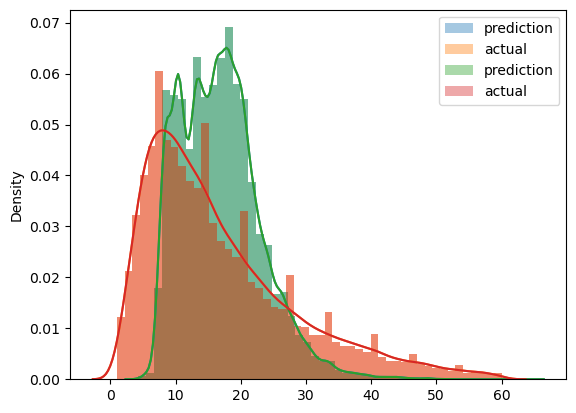

In [28]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()
plt.show()

In [27]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [29]:
df_train = read_dataframe(os.path.join(p.parents[0], 'data/green_tripdata_2021-01.parquet'))
df_val = read_dataframe(os.path.join(p.parents[0], 'data/green_tripdata_2021-02.parquet'))

In [30]:
len(df_train), len(df_val)

(73908, 61921)

In [31]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [32]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [33]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479579217725394

In [35]:
lr = Lasso(0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.233436225720547

In [36]:
lr = Ridge(0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.342569094062418

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Homework

In [72]:
## Q1. Downloading the data
### Download the data for January and February 2021.
### Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".
### Read the data for January. How many records are there?
df_hw = pd.read_parquet(os.path.join(p.parents[0], 'data/fhv_tripdata_2021-01.parquet'))
df_hw.info()

### Answer : 1154112 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [73]:
df_hw.head(10)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,NaN,71.0,None,B00037
6,B00037,2021-01-01 00:18:12,2021-01-01 00:30:04,NaN,91.0,None,B00037
7,B00037,2021-01-01 00:36:15,2021-01-01 00:45:08,NaN,39.0,None,B00037
8,B00037,2021-01-01 00:55:04,2021-01-01 01:13:02,NaN,37.0,None,B00037
9,B00037,2021-01-01 00:48:40,2021-01-01 01:12:02,NaN,39.0,None,B00037


In [74]:
df_hw.iloc[0]['dropOff_datetime'] - df_hw.iloc[0]['pickup_datetime']

Timedelta('0 days 00:17:00')

In [75]:
df_hw.iloc[1]['dropOff_datetime'] - df_hw.iloc[1]['pickup_datetime']

Timedelta('0 days 00:17:00')

In [76]:
df_hw.iloc[2]['dropOff_datetime'] - df_hw.iloc[2]['pickup_datetime']

Timedelta('0 days 01:50:00')

In [77]:
df_hw['duration'] = df_hw.dropOff_datetime - df_hw.pickup_datetime
df_hw[['duration']].head()

,duration
0,0 days 00:17:00
1,0 days 00:17:00
2,0 days 01:50:00
3,0 days 00:08:17
4,0 days 00:15:13


In [78]:
df_hw.duration = df_hw.duration.apply(lambda td: td.total_seconds() / 60)
df_hw[['duration']].head()

,duration
0,17.000000
1,17.000000
2,110.000000
3,8.283333
4,15.216667


In [79]:
## Q2. Computing duration
### Now let's compute the duration variable. It should contain the duration of a ride in minutes.
### What's the average trip duration in January?
df_hw.duration.describe()

### Answer: 19.16

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
25%      7.766667e+00
50%      1.340000e+01
75%      2.228333e+01
max      4.233710e+05
Name: duration, dtype: float64

In [113]:
### Data Preparation
### keep only the records where the duration was between 1 and 60 minutes (inclusive).
df_hw_filt = df_hw[(df_hw.duration >= 1) & (df_hw.duration <= 60)]

In [114]:
print(f'Records removed after filtering is {len(df_hw) - len(df_hw_filt)} rows.')

Records removed after filtering is 44286 rows.


C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


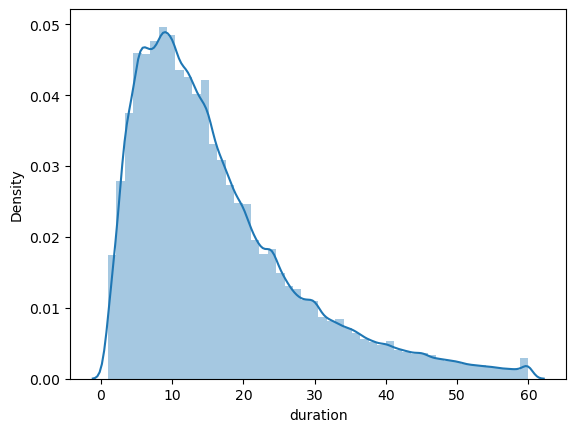

In [82]:
import seaborn as sns

sns.distplot(df_hw_filt.duration)
plt.show()

In [115]:
## Q3. Missing values
### The features we'll use for our model are the pickup and dropoff location IDs.
### But they have a lot of missing values there. Let's replace them with "-1".
### What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

print(f'Missing values fraction on the pickup location ID: {100*df_hw_filt.PUlocationID.isna().sum()/len(df_hw_filt):.2f}%')
print(f'Missing values fraction on the dropoff location ID: {100*df_hw_filt.DOlocationID.isna().sum()/len(df_hw_filt):.2f}%')
### Answer: 83.53%

Missing values fraction on the pickup location ID: 83.53%
Missing values fraction on the dropoff location ID: 13.33%


In [116]:
## Fillna with value "-1"
df_hw_filt.PUlocationID = df_hw_filt.PUlocationID.fillna(-1)
df_hw_filt.DOlocationID = df_hw_filt.DOlocationID.fillna(-1)

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [117]:
print(f'Missing values fraction on the pickup location ID: {100*df_hw_filt.PUlocationID.isna().sum()/len(df_hw_filt):.2f}%')
print(f'Missing values fraction on the dropoff location ID: {100*df_hw_filt.DOlocationID.isna().sum()/len(df_hw_filt):.2f}%')

Missing values fraction on the pickup location ID: 0.00%
Missing values fraction on the dropoff location ID: 0.00%


In [118]:
df_hw_filt['PUlocationID'].value_counts().nlargest(2)

-1.0      927008
 221.0      8330
Name: PUlocationID, dtype: int64

In [119]:
## Q4. One-hot encoding

# Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

# * Turn the dataframe into a list of dictionaries
# * Fit a dictionary vectorizer 
# * Get a feature matrix from it

## What's the dimensionality of this matrix? (The number of columns)
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

categorical = ['PUlocationID', 'DOlocationID']
# numerical = ['trip_distance']

df_hw_filt[categorical] = df_hw_filt[categorical].astype(str)

C:\Users\rizdi\miniconda3\envs\env_python38\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [120]:
df_hw_filt.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [121]:
df_hw_filt[categorical].iloc[:7].to_dict(orient='records')

[{'PUlocationID': '-1.0', 'DOlocationID': '-1.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '-1.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '72.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '61.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '71.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '91.0'},
 {'PUlocationID': '-1.0', 'DOlocationID': '39.0'}]

In [145]:
train_dicts = df_hw_filt[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [146]:
X_train

### Answer: 525

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [147]:
X_train.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [143]:
df_hw_filt.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,-1.0,-1.0,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,-1.0,-1.0,None,B00009,17.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,-1.0,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,-1.0,61.0,None,B00037,15.216667
5,B00037,2021-01-01 00:59:02,2021-01-01 01:08:05,-1.0,71.0,None,B00037,9.050000


In [148]:
## Q5. Training a model

# Now let's use the feature matrix from the previous step to train a model. 

# * Train a plain linear regression model with default parameters 
# * Calculate the RMSE of the model on the training data

# What's the RMSE on train?
target = 'duration'
y_train = df_hw_filt[target].values

In [149]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

error_rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'RMSE: {error_rmse}')

### Answer: 10.52

RMSE: 10.528519107223724


In [138]:
## Q6. Evaluating the model

# Now let's apply this model to the validation dataset (Feb 2021). 

# What's the RMSE on validation?

In [136]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df_hw = pd.read_csv(filename)
    elif filename.endswith('.parquet'):
        df_hw = pd.read_parquet(filename)
    
    df_hw['duration'] = df_hw.dropOff_datetime - df_hw.pickup_datetime
    df_hw.duration = df_hw.duration.apply(lambda td: td.total_seconds() / 60)
    df_hw = df_hw[(df_hw.duration >= 1) & (df_hw.duration <= 60)]
    df_hw.PUlocationID = df_hw.PUlocationID.fillna(-1)
    df_hw.DOlocationID = df_hw.DOlocationID.fillna(-1)
    categorical = ['PUlocationID', 'DOlocationID']
    df_hw[categorical] = df_hw[categorical].astype(str)
    
    return df_hw

In [137]:
df_val = read_dataframe(os.path.join(p.parents[0], 'data/fhv_tripdata_2021-02.parquet'))
df_val.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173.0,82.0,None,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173.0,56.0,None,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82.0,129.0,None,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1.0,225.0,None,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1.0,61.0,None,B00037,8.966667


In [139]:
df_val.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [140]:
categorical = ['PUlocationID', 'DOlocationID']
val_dicts = df_val[categorical].to_dict(orient='records')

dv_val = DictVectorizer()
X_val = dv_val.fit_transform(val_dicts)

In [152]:
target = 'duration'
y_val = df_val[target].values

In [153]:
lr_val = LinearRegression()
lr_val.fit(X_val, y_val)

LinearRegression()

In [154]:
y_pred_val = lr_val.predict(X_val)

error_rmse = mean_squared_error(y_val, y_pred_val, squared=False)
print(f'RMSE: {error_rmse}')

RMSE: 10.958228441969439
